Note: This is a work in progress. I am changing things constantly.

## 1 Intro

The sinking of the RMS Titanic is one of the most infamous shipwrecks in history.  On April 15, 1912, during her maiden voyage, the Titanic sank after colliding with an iceberg, killing 1502 out of 2224 passengers and crew. This sensational tragedy shocked the international community and led to better safety regulations for ships.

### 1.1 Objective/Initial Question

In this report, I aim to complete the analysis of what sorts of people were likely to survive. I plan to apply the tools of machine learning to predict which passengers were more likely to survive the tragedy.

## 2 Obtain the data

### 2.1 Import Libraries

In [32]:
# Handle table-like data and matrices
import numpy as np
import pandas as pd

# Visualisation
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns

# Configure visualisations
%matplotlib inline
mpl.style.use( 'ggplot' )
sns.set_style( 'white' )
pylab.rcParams[ 'figure.figsize' ] = 8 , 6

### 2.2 Setup Helper Functions

In [399]:
def plot_hist(var):
    plt.hist(var)
    plt.xlabel(str(var.name))
    plt.ylabel('Frequency')
    plt.title('The frequency distribution of ' + str(var.name).lower())

def plot_histograms( df , variables , n_rows , n_cols ):
    fig = plt.figure( figsize = ( 16 , 12 ) )
    for i, var_name in enumerate( variables ):
        ax=fig.add_subplot( n_rows , n_cols , i+1 )
        df[ var_name ].hist( bins=10 , ax=ax )
        ax.set_title( 'Skew: ' + str( round( float( df[ var_name ].skew() ) , ) ) ) 
        # + ' ' + var_name ) #var_name+" Distribution")
        ax.set_xticklabels( [] , visible=False )
        ax.set_yticklabels( [] , visible=False )
    fig.tight_layout()  # Improves appearance a bit.
    plt.show()

def plot_distribution( df , var , target , **kwargs ):
    row = kwargs.get( 'row' , None )
    col = kwargs.get( 'col' , None )
    facet = sns.FacetGrid( df , hue=target , aspect=4 , row = row , col = col )
    facet.map( sns.kdeplot , var , shade= True )
    #facet.set( xlim=( 0 , df[ var ].max() ) )
    facet.set( xlim=( 0 , 150 ) )
    facet.add_legend()
    facet.set_axis_labels(var, 'Probability Density')

def plot_categories( df , cat , target , **kwargs ):
    row = kwargs.get( 'row' , None )
    col = kwargs.get( 'col' , None )
    facet = sns.FacetGrid( df , row = row , col = col )
    facet.map( sns.barplot , cat , target )
    facet.add_legend()

def plot_correlation_map( df ):
    corr = df.corr()
    _ , ax = plt.subplots( figsize =( 12 , 10 ) )
    cmap = sns.diverging_palette( 220 , 10 , as_cmap = True )
    _ = sns.heatmap(
        corr, 
        cmap = cmap,
        square=True, 
        cbar_kws={ 'shrink' : .9 }, 
        ax=ax, 
        annot = True, 
        annot_kws = { 'fontsize' : 12 }
        
    
    )

def describe_more( df ):
    var = [] ; l = [] ; t = []
    for x in df:
        var.append( x )
        l.append( len( pd.value_counts( df[ x ] ) ) )
        t.append( df[ x ].dtypes )
    levels = pd.DataFrame( { 'Variable' : var , 'Levels' : l , 'Datatype' : t } )
    levels.sort_values( by = 'Levels' , inplace = True )
    return levels

def plot_variable_importance( X , y ):
    tree = DecisionTreeClassifier( random_state = 99 )
    tree.fit( X , y )
    plot_model_var_imp( tree , X , y )
    
def plot_model_var_imp( model , X , y ):
    imp = pd.DataFrame( 
        model.feature_importances_  , 
        columns = [ 'Importance' ] , 
        index = X.columns 
    )
    imp = imp.sort_values( [ 'Importance' ] , ascending = True )
    imp[ : 10 ].plot( kind = 'barh' )
    print (model.score( X , y ))

### 2.3 Load data

Note: I retrospectively set the index column after reviewing the dataframe in the next section. I briefly checked that all the PassengerId values were unique to ensure it made sense to have it as an index column.

In [308]:
df = pd.read_csv('titanic_data.csv', index_col='PassengerId')
train = pd.read_csv('train.csv', index_col='PassengerId')
test = pd.read_csv('test.csv', index_col='PassengerId')

#full = train.append(test, ignore_index= True, sort=False)
#titanic = full[:891]

#print("Dataset Shapes - Full: {}, Titanic: {} ".format(full.shape, titanic.shape))

Now, let's look at the data set we are working with. But before I do, I'll past the variable definitions provided by Kaggle that came with the  data set.

#### Variable definitions

- Survival:	Survival	(0 = No, 1 = Yes)
- Pclass: Ticket class	(1 = 1st, 2 = 2nd, 3 = 3rd)
- Sex: Sex	
- Age: Age in years	
- Sibsp: # of siblings / spouses aboard the Titanic	
- Parch: # of parents / children aboard the Titanic	
- Ticket: Ticket number	
- Fare:	Passenger fare	
- Cabin: Cabin number	
- Embarked:	Port of Embarkation	(C = Cherbourg, Q = Queenstown, S = Southampton)

Now let's look at the data!

In [310]:
df.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


Having seen the data, i'm documenting questions I have at this stage which may lead to interesting results. Of course as I learn more about the data, this is likely to change. However below is what I have listed as a starting point.

#### Potentially Interesting Questions

- Are women and children more likely to have survived? (Why: The movies portray women and children to be given priority) 
- Are those who are over sixty less likely to have survived? (Why: Declining health)
- Are those who paid less for their ticket/or bought a lower class ticket more likely to have survived? (Why: "Harder life assumption")
- How many complete families survived (i.e. where people had siblings/spouses/parches/children and I am able to locate their families through last name.
- Where families didn't survive, what kind of member didn't?
- Are people with significantly discounted tickets more likely to survive?
- Were there any discounts given to elderly/young people?
- Did men or women pay more on average for their ticket?
- Were certain ages of men/women more likely to travel alone?
- Were lone travellers more likely to survive?

What's the shape of the data?

In [311]:
df.shape

(891, 11)

We have 891 rows and 12 columns. 

What data types are we dealing with?

In [312]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 11 columns):
Survived    891 non-null int64
Pclass      891 non-null int64
Name        891 non-null object
Sex         891 non-null object
Age         714 non-null float64
SibSp       891 non-null int64
Parch       891 non-null int64
Ticket      891 non-null object
Fare        891 non-null float64
Cabin       204 non-null object
Embarked    889 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 83.5+ KB


Reviwing the dataframe table, table info and table summary above, I am going to start listing a few potential issues which may need cleansing.
- Incomplete data for the "Age", "Cabin" and "Embarked" columns. 
- I can also see that we have several columns which have been loaded as an object. I may need to convert these to a string later.
- Some of the name fields have two names with one bracketed (potentially someone buying a ticket on the behalf of someone else).

#### Fixing problems in the data

I know that the data has missing values for Age. Therefore I am going to take the mean age and set the remaining values to this.

In [313]:
df['Age'] = df['Age'].fillna(df['Age'].mean())

print(df['Age'].mean())

29.69911764705882


All the blank age values have been populated with 29.699118.

We are missing two values for embarked which I am happy to ignore for now. As for cabin, there are only 204/891 values provided. At this point, I don't know what analysis I plan to do with the cabin field so I will leave it as-is for now.

## 3 Exploring the data

### 3.1 Statistical summaries and visualisations

I'll use the describe function of pandas to give me an instant view of what the distributions are like for the variables that have a quantitative data type.

In [314]:
df.describe()

,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,0.486592,0.836071,13.002015,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,22.000000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,29.699118,0.000000,0.000000,14.454200
75%,1.000000,3.000000,35.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


I'm quite a visual person. I don't immediately see any interesting insights from looking at this statistical summary. To aid this i'm going to plot the distributions.

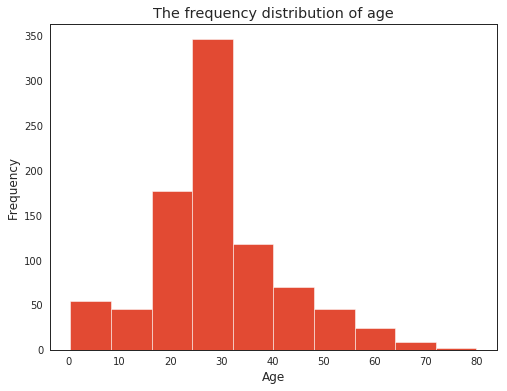

In [409]:
plot_hist(df.Age)

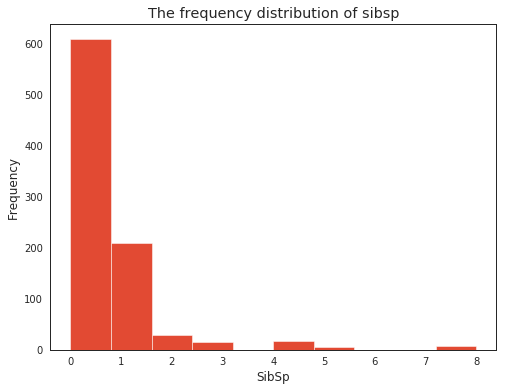

In [316]:
plot_hist(df.SibSp)

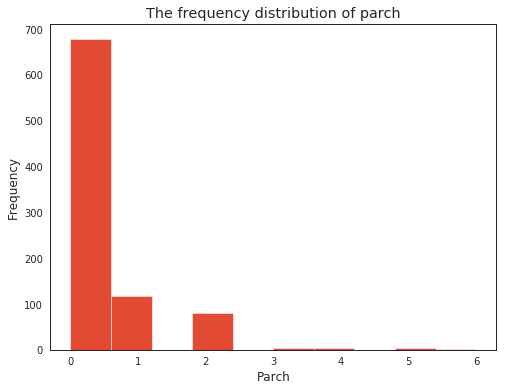

In [317]:
plot_hist(df.Parch)

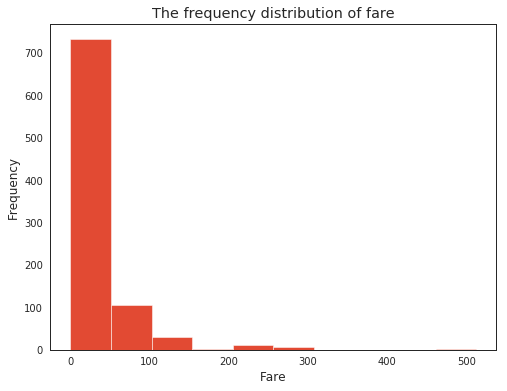

In [318]:
plot_hist(df.Fare)

The distribution appears to highlight outliers (as high as 500). This leads me to go a step further and calculate the median. As we can below, it is significantly different from the mean.

In [332]:
print(df['Fare'].median())

14.4542


#### Exploring the question: are women and children more likely to have survived than men?

Here I am going to form three distinct groups which I will use to see if there is a story worth telling here. I'll group the data into children (Age < 18) and men and women. I also may form a fourth group of people over age sixty.

In [371]:
for index, row in df.iterrows():

    x = row['Age']


    if x < 18:
        group = 'Child'
    elif x > 60:
        group = 'Senior'
    elif row.Sex == 'male':
        group = 'Adult Man'
    elif row.Sex == 'female':
        group = 'Adult Woman'

    df.loc[index, 'Age/Sex Grouping'] = group
    
grouped = df.groupby('Age/Sex Grouping')
grouped.mean()

,Survived,Pclass,Age,SibSp,Parch,Fare
Age/Sex Grouping,,,,,,
Adult Man,0.168000,2.388000,31.647381,0.294000,0.136000,24.519523
Adult Woman,0.750000,2.093750,31.890833,0.589844,0.574219,46.859653
Child,0.539823,2.584071,9.041327,1.460177,1.053097,31.220798
Senior,0.227273,1.590909,66.022727,0.136364,0.272727,41.371214


With a mean significantly above the overall mean for survival (0.38), it appears that if you were a woman (0.75) or child (0.54), your chances of survival were significantly higher. As we know that there were limited lifeboats on the titanic, this would make sense. To prove/disprove this, I will look at performing statistical tests in the conclusion part of this report.

In order to understand other discrepancies that could have led to survival. I think it makes sense to maintain these groups through out this study - given how drastic the survival rates are between them.

#### A heat map of correlation 

The below is a heat map of the strength of correlation (Pearson's r) of the variables we have available. This should hopefully give me more of an indication of which variables are strongly correlated - paying particular attention to survival.

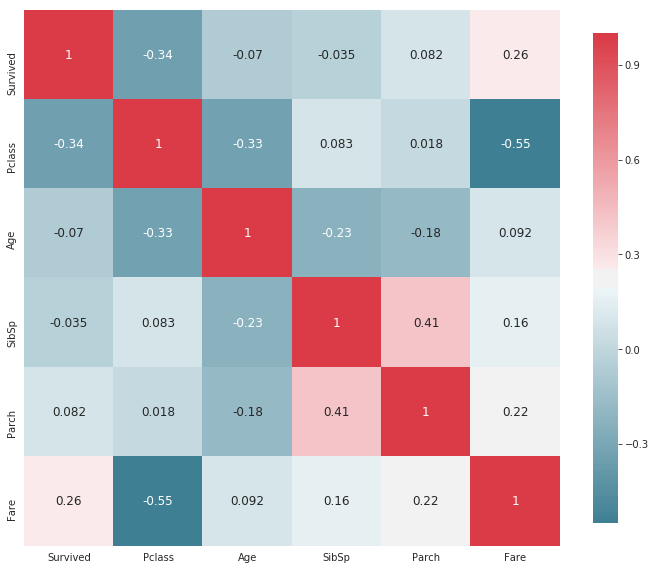

In [400]:
plot_correlation_map(df)

The correlation heatmap shows us that there are some relationships that may lead to interesting insights by further investigation.

**Relationships that appear to impact survival**
- PClass and Survived (-0.55) 
- Fare and Survived (0.26)

Those with a lower class ticket (i.e. 3) seems to be negatively correlated with survival. Those who payed more for their ticket appears to have a positive impact on whether they survived. Could preferential treatment possibly have been given to those with a higher class ticket? Could bribery have played a hand? Or could the upper class be better at getting what they want?

**Other interesting relationships**
- Parch and SibSp (0.41)
- Age and SibSp (-0.31)
- Age and PClass (-0.37)
- Parch and Age (-0.19)
- Parch and SibSp (0.41)



I'm going to discount Fare and PClass (-0.55) because I expect there to be an inverse relationship between the price paid for the ticket and the class of the ticket (where 1 is 1st class and 3 is 3rd)

### Pairwise plots

The pair plot below shows pairwise relationships in the data set. This gives a quick idea of what variables drive separation and is a useful tool for taking further for machine learning algorithms.

- Where plotting pairwise variables that are non-identical, produces a scatter plot 
- Where plotting pairwise variables that are identical - a kernal density estimation plot is produced (similar to a histogram)

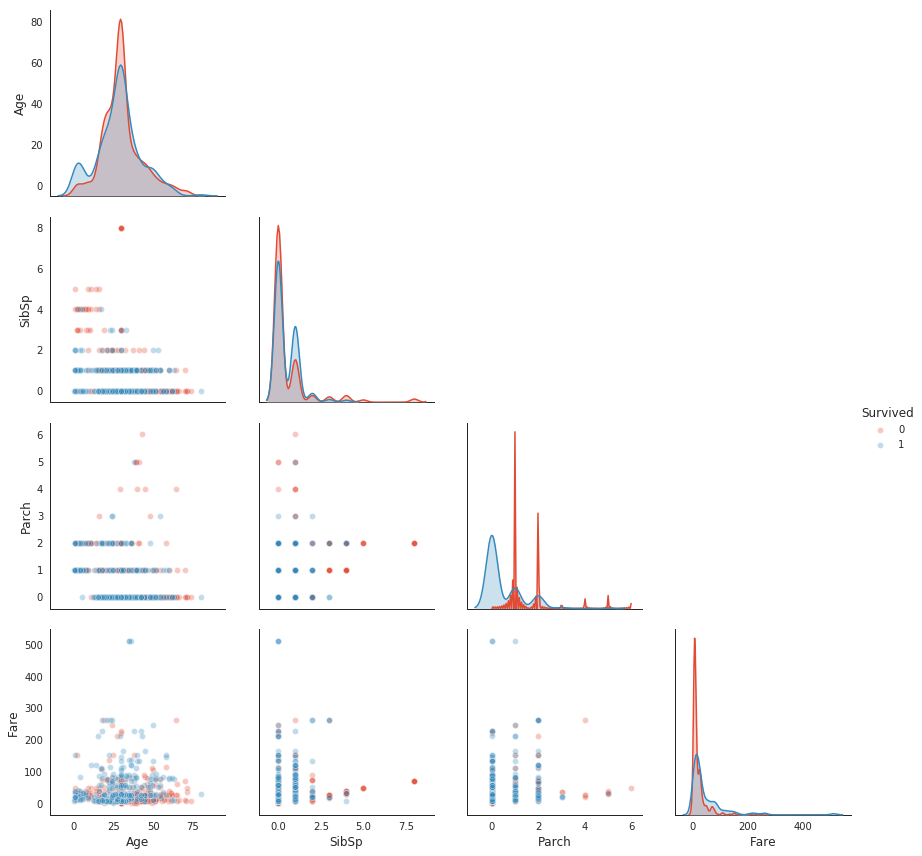

In [415]:
#This produces a number of plots with variables paired up. This should hopefully give me an indication of how easy
# it will be to decide whether a person would have survived or not based on the data we have available to us.
pair_plot = sns.pairplot(df,
            hue= 'Survived', # The target, the variable we are trying to see separation for.
            vars= ['Age', 'SibSp','Parch', 'Fare'], # The variables we are working with
            height=3, #size of each plot
            diag_kind='kde', #Kind of plot for the diagonal subplots
            plot_kws=dict(alpha=0.3))

#The below code hides the top right triangle of plots (which is a mirror of the bottom left)
for i, j in zip(*np.triu_indices_from(pair_plot.axes, 1)):
    pair_plot.axes[i, j].set_visible(False)

It doesn't appear like we can conclusively say that one variable acts as a clear differentiator as to whether a person would have survived or not. However, there appears to be enough separation to achieve some sort of conclusion by combining variables (features in a machine learning algorithm). 

**Those with a low Parch (# of parents / children aboard) and/or a low SibSp (# of siblings / spouses) appear to have a higher chance of survival than those with a high Parch.** 

(Looking at Age-Parch, SibSp-Parch & Parch-Parch)

All graphs clearly show that a low Parch is better.

(SibSp-Parch)

Appears that those with a low amount of siblings and parents/children aboard had a really high chance of survival (the bottom left of the graph is very blue). 

(SibSp-SibSp looks inconclusive to me - although the data is skewed right, it appears to show a similar shape for both survival outcomes).

**Potential justifcation**

These trends don't sound suprising. Potential justification could be that parents/children would spend more time collecting their families. Another potentital justification (imagine queuing for a theme park ride) could be that families were to big to fit on lifeboats together, and that smaller travellers were called forward in the queue. If this were true, we would expect a similar relationship for the SibSp variable.

### Further explore the distribution for some of the interesting relationships

Going forward there are a few main areas I want to further investigate that I feel could lead to an interesting story.
- The relationship between class/ticket price and survival
- How survival stats varied between families and lone travellers  

#### The relationship between class/ticket price and survival

Carrying on with the groupings established earlier in this study (based on age/sex), here we will analyse how the two variable 'Pclass' and 'Fare' are related to 'Survived'.

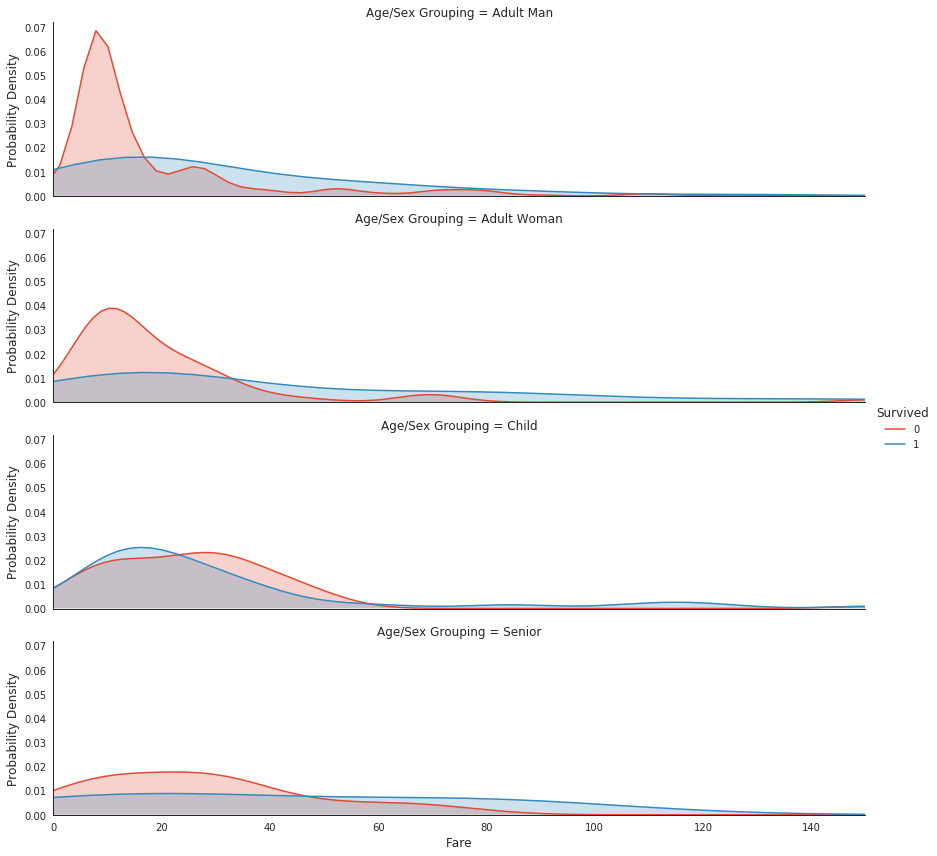

In [381]:

plot_distribution( df , var = 'Fare' , target = 'Survived', row='Age/Sex Grouping')

In [363]:
fare_groups = df.groupby('Pclass')
survived_fare_groups = fare_groups['Survived'].mean()
print(survived_fare_groups )
print(fare_groups.groups)

Pclass
1    0.629630
2    0.472826
3    0.242363
Name: Survived, dtype: float64
{1: Int64Index([  2,   4,   7,  12,  24,  28,  31,  32,  35,  36,
            ...
            854, 857, 858, 863, 868, 872, 873, 880, 888, 890],
           dtype='int64', name='PassengerId', length=216), 2: Int64Index([ 10,  16,  18,  21,  22,  34,  42,  44,  54,  57,
            ...
            849, 855, 862, 865, 866, 867, 875, 881, 884, 887],
           dtype='int64', name='PassengerId', length=184), 3: Int64Index([  1,   3,   5,   6,   8,   9,  11,  13,  14,  15,
            ...
            876, 877, 878, 879, 882, 883, 885, 886, 889, 891],
           dtype='int64', name='PassengerId', length=491)}


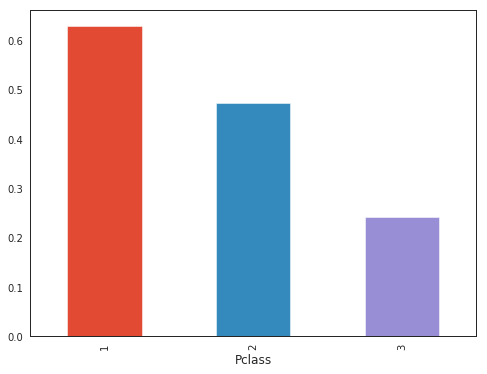

In [367]:
survived_fare_groups.plot.bar()

#### How survival stats varied between families and lone travellers


Looking further ahead, I wonder if new features could be engineered e.g. 
- lone traveller/couple/family from Sibsp/Parch & Last Name.
- discounted ticket from an incongruent Pclass and Fare.
- Family role - i.e. mother, father, brother, sister, spouse (might be able to infer spouse from the bracketed name)

AttributeError: 'str' object has no attribute 'get'

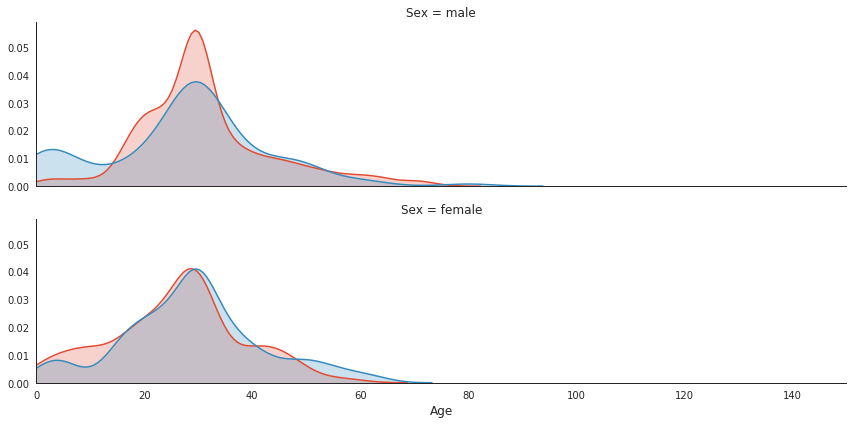

In [375]:
plot_distribution( df , var = 'Age' , target = 'Survived' , row = 'Sex' )

/Applications/anaconda3/lib/python3.6/site-packages/seaborn/axisgrid.py:715: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


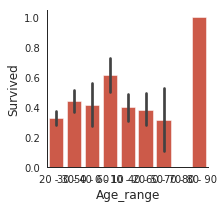

In [209]:
plot_categories(df,  target = 'Survived', cat = 'Age_range')

(array([549.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 342.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

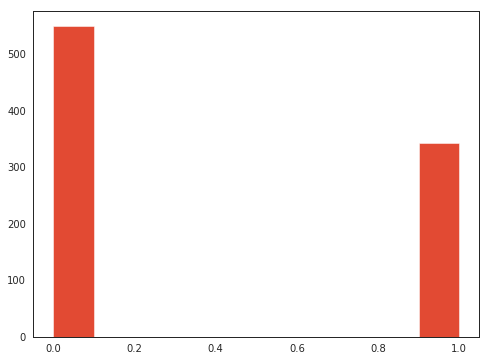

In [216]:
plt.hist(df.Survived)

## 4 Draw Conclusions

Here I will use either statistics or machine learning to really confirm what the data is telling us and answer the primary question

# Ignore for now

In [66]:
df[(df.Pclass == 1) & (df.Fare < 20) ]

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
264,0,1,"Harrison, Mr. William",male,40.0,0,0,112059,0.0,B94,S
634,0,1,"Parr, Mr. William Henry Marsh",male,NaN,0,0,112052,0.0,NaN,S
807,0,1,"Andrews, Mr. Thomas Jr",male,39.0,0,0,112050,0.0,A36,S
816,0,1,"Fry, Mr. Richard",male,NaN,0,0,112058,0.0,B102,S
823,0,1,"Reuchlin, Jonkheer. John George",male,38.0,0,0,19972,0.0,NaN,S
873,0,1,"Carlsson, Mr. Frans Olof",male,33.0,0,0,695,5.0,B51 B53 B55,S


#### Age and Survived

Male and Female grouping

In [142]:


sex_group = df.groupby('Sex')
male_group = sex_group.get_group('male')
female_group = sex_group.get_group('female')

x = male_group.iloc[1:100]
#print(x['Age'])


#plt.hist(male_group['Survived'])


#sex_group.plot(x='Age', y='Survived')
#plt.scatter(sex_group['Age'], sex_group['Survived'])

In [193]:
from math import ceil, floor

def create_range(df, var, base):
    """Takes a variable and returns the variable in a range - useful for producing histograms
    df = dataframe for function to act on
    var = the variable you would like to convert into a range (string)
    base = the upper and lower bounds of the range
    
    """

    for index, row in df.iterrows():

        x = row[var]
        lower = int(base * floor(float(x)/base))
        if x % base != 0:
            upper = int(base * ceil(float(x)/base))
        else:
            upper = lower + base

        df.loc[index, '{}_range'.format(var)] = '{} - {}'.format(lower, upper)
    
    return df



In [204]:
create_range(df, 'Age', 10)

#del df['Age_range']
    
df.head(20)

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Age_range
PassengerId,,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.000000,1,0,A/5 21171,7.2500,NaN,S,20 - 30
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.000000,1,0,PC 17599,71.2833,C85,C,30 - 40
3,1,3,"Heikkinen, Miss. Laina",female,26.000000,0,0,STON/O2. 3101282,7.9250,NaN,S,20 - 30
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.000000,1,0,113803,53.1000,C123,S,30 - 40
5,0,3,"Allen, Mr. William Henry",male,35.000000,0,0,373450,8.0500,NaN,S,30 - 40
6,0,3,"Moran, Mr. James",male,29.699118,0,0,330877,8.4583,NaN,Q,20 - 30
7,0,1,"McCarthy, Mr. Timothy J",male,54.000000,0,0,17463,51.8625,E46,S,50 - 60
8,0,3,"Palsson, Master. Gosta Leonard",male,2.000000,3,1,349909,21.0750,NaN,S,0 - 10
9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.000000,0,2,347742,11.1333,NaN,S,20 - 30
